In [1]:
#!/usr/bin/env python

# --------------------------------------------------------
# Py Faster R-CNN train notebook 
# based on py-faster-rcnn Written by Ross Girshick from Microsoft (MIT License)
# Edited by Joris GUERRY from ONERA
# --------------------------------------------------------

"""Train a Faster R-CNN network using alternating optimization.
This tool implements the alternating optimization algorithm described in our
NIPS 2015 paper ("Faster R-CNN: Towards Real-time Object Detection with Region
Proposal Networks." Shaoqing Ren, Kaiming He, Ross Girshick, Jian Sun.)
"""

import _init_paths
from fast_rcnn.train import get_training_roidb, train_net
from fast_rcnn.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from datasets.factory import get_imdb
from rpn.generate import imdb_proposals
import argparse
import pprint
import numpy as np
import sys, os
import multiprocessing as mp
import cPickle
import shutil
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
def parse_args():
    """
    Parse input arguments
    """
    parser = argparse.ArgumentParser(description='Train a RPN')
    parser.add_argument('--gpu_id', dest='gpu_id', type=int)
    parser.add_argument('--max_iters', dest='max_iters', type=int)
    parser.add_argument('--path_net_proto', dest='path_net_proto', type=str)
    parser.add_argument('--path_net_weights', dest='path_net_weights', type=str)
    parser.add_argument('--imdb_name', dest='imdb_name',type=str)
    parser.add_argument('--path_cfg', dest='path_cfg',type=str)
    parser.add_argument('--output_dir', dest='output_dir', type=str)
    parser.add_argument('--output_file_name', dest='output_file_name', type=str)
    parser.add_argument('--path_proposal', dest='path_proposal', type=str)

    if len(sys.argv) == 1:
        parser.print_help()
        sys.exit(1)

    args = parser.parse_args()
    return args

def get_roidb(imdb_name, rpn_file=None):
    print 'Requiring dataset `{:s}` for training'.format(imdb_name)
    imdb = get_imdb(imdb_name)
    print 'Loaded dataset `{:s}` for training'.format(imdb.name)
    imdb.set_proposal_method(cfg.TRAIN.PROPOSAL_METHOD)
    print 'Set proposal method: {:s}'.format(cfg.TRAIN.PROPOSAL_METHOD)
    if rpn_file is not None:
        imdb.config['rpn_file'] = rpn_file
    print 'config[rpn_file]: {:s}'.format(imdb.config['rpn_file'])
    roidb = get_training_roidb(imdb)
    return roidb, imdb

def _init_caffe(cfg):
    """Initialize pycaffe in a training process.
    """

    import caffe
    # fix the random seeds (numpy and caffe) for reproducibility
    np.random.seed(cfg.RNG_SEED)
    caffe.set_random_seed(cfg.RNG_SEED)
    # set up caffe
    caffe.set_mode_gpu()
    caffe.set_device(cfg.GPU_ID)
def filter_roidb(roidb):
    """Remove roidb entries that have no usable RoIs."""

    def is_valid(entry):
        # Valid images have:
        #   (1) At least one foreground RoI OR
        #   (2) At least one background RoI
        overlaps = entry['max_overlaps']
        # find boxes with sufficient overlap
        fg_inds = np.where(overlaps >= cfg.TRAIN.FG_THRESH)[0]
        # Select background RoIs as those within [BG_THRESH_LO, BG_THRESH_HI)
        bg_inds = np.where((overlaps < cfg.TRAIN.BG_THRESH_HI) &
                           (overlaps >= cfg.TRAIN.BG_THRESH_LO))[0]
        # image is only valid if such boxes exist
        valid = len(fg_inds) > 0 or len(bg_inds) > 0
        return valid

    num = len(roidb)
    filtered_roidb = [entry for entry in roidb if is_valid(entry)]
    num_after = len(filtered_roidb)
    print 'Filtered {} roidb entries: {} -> {}'.format(num - num_after,
                                                       num, num_after)
    return filtered_roidb




In [3]:
path_net_weights = '/home/jogue/workspace/caffemodels/nyud-fcn32s-color-heavy.caffemodel'
solver_prototxt = '/home/jogue/workspace/jg_pfr/models/nyud_v2_40gupta/VGG16_from_FCN/faster_rcnn_end2end/solver2.prototxt'

#path_net_weights = '/home/jogue/workspace/caffemodels/nyud-fcn32s-color-heavy.caffemodel'
#solver_prototxt = '/home/jogue/workspace/jg_pfr/models/nyud_v2_40gupta/VGG16/jg_faster_rcnn_end2end'



path_proposal = '/home/jogue/workspace/jg_pfr/output/2017janvier22/'
output_dir = '/home/jogue/workspace/jg_pfr/output/2017janvier22/'
imdb_train_name = 'nyud_v2_trainvalGupta_rgb_i_100_8bits'
imdb_test_name = 'nyud_v2_testGupta_rgb_i_100_8bits'


cfg_from_file('/home/jogue/workspace/jg_pfr/experiments/cfgs/nyud_v2_40gupta/cfg_end2end.yml')
cfg.GPU_ID = 0
#print 'Init model: {}'.format(path_net_weights)
#print 'RPN proposals: {}'.format(path_proposal)
#print('Using config:')
#pprint.pprint(cfg)

In [4]:
import caffe
_init_caffe(cfg)

In [5]:
roidb_train, imdb_train = get_roidb(imdb_train_name, rpn_file=path_proposal)
roidb_test, imdb_test = get_roidb(imdb_test_name, rpn_file=path_proposal)
print 'Output will be saved to `{:s}`'.format(output_dir)

Requiring dataset `nyud_v2_trainvalGupta_rgb_i_100_8bits` for training
self.num_classes = 41
Loaded dataset `nyud_v2_trainvalGupta_rgb_i_100_8bits` for training
Set proposal method: gt
config[rpn_file]: /home/jogue/workspace/jg_pfr/output/2017janvier22/
Appending horizontally-flipped training examples...
nyud_v2_trainvalGupta_rgb_i_100_8bits gt roidb loaded from /home/jogue/workspace/jg_pfr/data/cache/nyud_v2_trainvalGupta_rgb_i_100_8bits_gt_roidb.pkl
done
Preparing training data...
done
Requiring dataset `nyud_v2_testGupta_rgb_i_100_8bits` for training
self.num_classes = 41
Loaded dataset `nyud_v2_testGupta_rgb_i_100_8bits` for training
Set proposal method: gt
config[rpn_file]: /home/jogue/workspace/jg_pfr/output/2017janvier22/
Appending horizontally-flipped training examples...
nyud_v2_testGupta_rgb_i_100_8bits gt roidb loaded from /home/jogue/workspace/jg_pfr/data/cache/nyud_v2_testGupta_rgb_i_100_8bits_gt_roidb.pkl
done
Preparing training data...
done
Output will be saved to `/home

In [6]:
# Train Fast R-CNN
#model_paths = train_net(args.path_net_proto, roidb, args.output_dir,pretrained_model=args.path_net_weights,max_iters=args.max_iters)
print 'Computing bounding-box regression targets...'
import roi_data_layer.roidb as rdl_roidb
bbox_means_train, bbox_stds_train = rdl_roidb.add_bbox_regression_targets(roidb_train)
bbox_means_test, bbox_stds_test = rdl_roidb.add_bbox_regression_targets(roidb_test)

Computing bounding-box regression targets...
num class in add_bbox_regression_targets : 41
bbox target means:
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
[ 0.  0.  0.  0.]
bbox target stdevs:
[[ 0.1  0.1  0.2  0.2]
 [ 0.1  0.1  0.2  0.2]
 [ 0.1  0.1  0.2  0.2]
 [ 

In [7]:
solver = caffe.SGDSolver(solver_prototxt)

RoiDataLayer: name_to_top: {'gt_boxes': 2, 'data': 0, 'im_info': 1}
RoiDataLayer: name_to_top: {'gt_boxes': 2, 'data': 0, 'im_info': 1}


In [8]:
solver.net.copy_from(path_net_weights)

In [9]:
def snapshot(bbox_stds,bbox_means):
        """Take a snapshot of the network after unnormalizing the learned
        bounding-box regression weights. This enables easy use at test-time.
        """
        print "Snapshotting..."
        scale_bbox_params = (cfg.TRAIN.BBOX_REG and
                             cfg.TRAIN.BBOX_NORMALIZE_TARGETS and
                             solver.net.params.has_key('bbox_pred'))

        if scale_bbox_params:
            # save original values
            orig_0 = solver.net.params['bbox_pred'][0].data.copy()
            orig_1 = solver.net.params['bbox_pred'][1].data.copy()

            # scale and shift with bbox reg unnormalization; then save snapshot
            solver.net.params['bbox_pred'][0].data[...] = (solver.net.params['bbox_pred'][0].data * bbox_stds[:, np.newaxis])
            solver.net.params['bbox_pred'][1].data[...] = (solver.net.params['bbox_pred'][1].data * bbox_stds + bbox_means)

        infix = ('_' + cfg.TRAIN.SNAPSHOT_INFIX if cfg.TRAIN.SNAPSHOT_INFIX != '' else '')
        filename = (solver_param.snapshot_prefix + infix +
                    '_iter_{:d}'.format(solver.iter) + '.caffemodel')
        filename = os.path.join(output_dir, filename)

        solver.net.save(str(filename))
        print 'Wrote snapshot to: {:s}'.format(filename)

        if scale_bbox_params:
            # restore net to original state
            solver.net.params['bbox_pred'][0].data[...] = orig_0
            solver.net.params['bbox_pred'][1].data[...] = orig_1

In [10]:
#solver.net.params['conv1_1'][0].data
#solver.

In [11]:
from caffe.proto import caffe_pb2
import google.protobuf as pb2
solver_param = caffe_pb2.SolverParameter()
with open(solver_prototxt, 'rt') as f:
    pb2.text_format.Merge(f.read(), solver_param)

In [12]:
max_iters = solver_param.max_iter

In [13]:
roidb_train = filter_roidb(roidb_train)
roidb_test = filter_roidb(roidb_test)

Filtered 0 roidb entries: 1590 -> 1590
Filtered 0 roidb entries: 1308 -> 1308


In [14]:
#solver.net.
#solver.test_nets[0].bottom_names

In [15]:
solver.net.layers[0].set_roidb(roidb_train)
solver.test_nets[0].layers[0].set_roidb(roidb_test)

In [16]:
from utils.timer import Timer

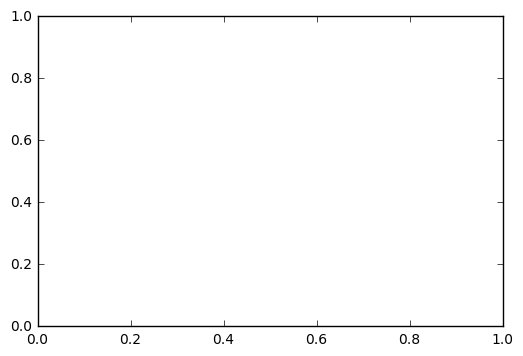

../lib/rpn/proposal_target_layer.py:166: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  fg_inds = npr.choice(fg_inds, size=fg_rois_per_this_image, replace=False)
../lib/rpn/proposal_target_layer.py:177: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bg_inds = npr.choice(bg_inds, size=bg_rois_per_this_image, replace=False)
../lib/rpn/proposal_target_layer.py:184: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  labels[fg_rois_per_this_image:] = 0
../lib/rpn/proposal_target_layer.py:127: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bbox_targets[ind, start:end] = bbox_target_data[ind, 1:]
../lib/rpn/proposal_target_layer.py:128: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in

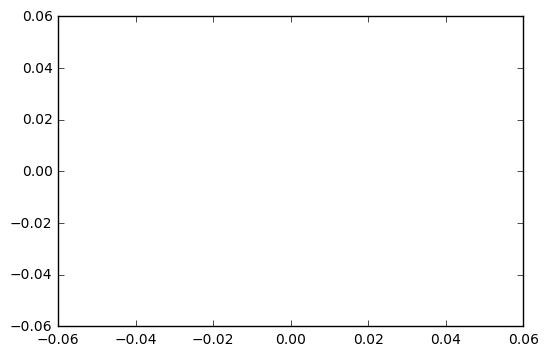

KeyboardInterrupt: 

In [17]:
"""Network training loop."""
last_snapshot_iter = -1
timer = Timer()
list_iters = []
list_accuracy_cls = []
list_loss_bbox = []
list_loss_cls = []
list_rpn_accuracy_cls = []
list_rpn_cls_loss = []
list_rpn_loss_bbox = []


while solver.iter < max_iters:
    # Make one SGD update
    timer.tic()
    solver.step(1)
    timer.toc()
    if solver.iter % solver_param.display == 0:
        list_iters.append(solver.iter)
        list_accuracy_cls.append(1.0*solver.net.blobs['accuracy_cls'].data[...])
        list_loss_bbox.append(1.0*solver.net.blobs['loss_bbox'].data[...])
        list_loss_cls.append(1.0*solver.net.blobs['loss_cls'].data[...])
        list_rpn_accuracy_cls.append(1.0*solver.net.blobs['rpn_accuracy_cls'].data[...])
        list_rpn_cls_loss.append(1.0*solver.net.blobs['rpn_cls_loss'].data[...])
        list_rpn_loss_bbox.append(1.0*solver.net.blobs['rpn_loss_bbox'].data[...])

        

    if solver.iter % 795 == 0:
        snapshot(bbox_means_train, bbox_stds_train)
    #    last_snapshot_iter = self.solver.iter
    #    model_paths.append(self.snapshot())

    #if last_snapshot_iter != self.solver.iter:
    #model_paths.append(self.snapshot())
#return model_paths

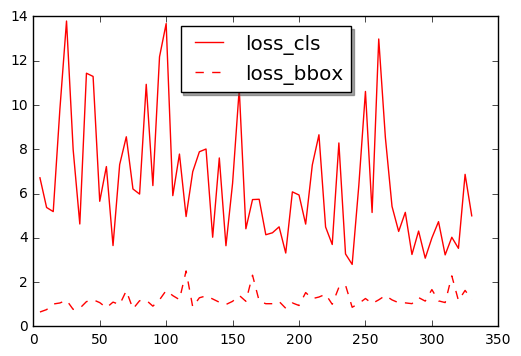

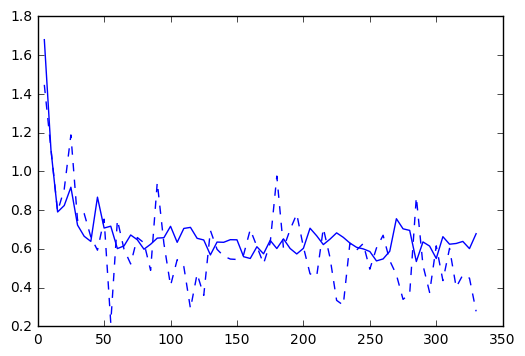

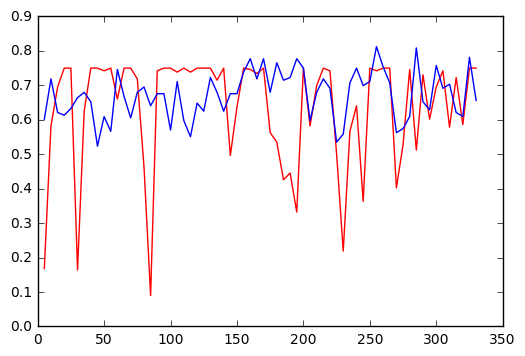

In [26]:
fig, ax = plt.subplots()
ax.plot(list_iters, list_loss_cls, 'r', label='loss_cls')
ax.plot(list_iters, list_loss_bbox, 'r--', label='loss_bbox')
ax.legend(loc='upper center', shadow=True, fontsize='x-large')
fig, ax = plt.subplots()
ax.plot(list_iters, list_rpn_cls_loss, 'b', label='rpn_cls_loss')
ax.plot(list_iters, list_rpn_loss_bbox, 'b--', label='rpn_loss_bbox')
ax.legend(loc='upper center', shadow=True, fontsize='x-large')
fig, ax = plt.subplots()
ax.plot(list_iters, list_accuracy_cls, 'r', label='accuracy_cls')
ax.plot(list_iters, list_rpn_accuracy_cls, 'b', label='rpn_accuracy_cls')
#plt.plot(list_iters, list_loss_bbox, list_iters, list_loss_cls, list_iters, list_rpn_accuracy_cls, list_iters, list_rpn_cls_loss, list_iters, list_rpn_loss_bbox)



plt.show()

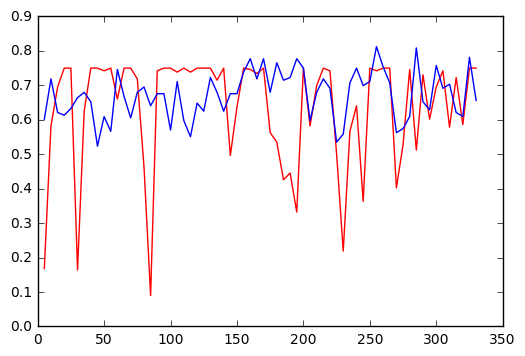

In [23]:


#plt.plot(list_iters, list_loss_bbox, list_iters, list_loss_cls, list_iters, list_rpn_accuracy_cls, list_iters, list_rpn_cls_loss, list_iters, list_rpn_loss_bbox)



plt.show()

In [ ]:
#fig, ax = plt.subplots()
#ax.hold(True)
#plt.show(False)
#plt.draw()
#points = ax.plot(list_iters, list_accuracy_cls, 'o')[0]
#plt.ion()
#print list_iters
        #print list_rpn_loss_bbox
        #print '----------------------------------------------------------'
        #print '-----------------------',solver.iter,'-------------------------'
        #print 'loss_bbox',solver.net.blobs['loss_bbox'].data
        #print 'loss_cls',solver.net.blobs['loss_cls'].data
        #print 'rpn_accuracy_cls',solver.net.blobs['rpn_accuracy_cls'].data
        #print 'rpn_cls_loss',solver.net.blobs['rpn_cls_loss'].data
        #print 'rpn_loss_bbox',solver.net.blobs['rpn_loss_bbox'].data
        
        #fig, ax = plt.subplots()
        #http://stackoverflow.com/questions/11874767/real-time-plotting-in-while-loop-with-matplotlib
        #points.set_data(list_iters, list_accuracy_cls)
        #ax.plot(list_iters, list_accuracy_cls, 'g--', label='accuracy_cls')
        #ax.plot(list_iters, list_loss_bbox, 'g', label='loss_bbox')
        #ax.plot(list_iters, list_loss_cls, 'r', label='loss_cls')
        #ax.plot(list_iters, list_rpn_accuracy_cls, 'b--', label='rpn_accuracy_cls')
        #ax.plot(list_iters, list_rpn_cls_loss, 'b', label='rpn_cls_loss')
        #ax.plot(list_iters, list_rpn_loss_bbox, 'c', label='rpn_loss_bbox')
        
        #plt.plot(list_iters, list_loss_bbox, list_iters, list_loss_cls, list_iters, list_rpn_accuracy_cls, list_iters, list_rpn_cls_loss, list_iters, list_rpn_loss_bbox)
        #fig.canvas.draw()
        
        #plt.pause(0.05)
        #plt.show()